## Tasks 1 and 2: Global moisture maps of MLS and UM data at 100 hPa
Assigned to Sierra Stevenson, JSIP intern under Dr. Jonathan Jiang and Dr. Longtao Wu<p>
This analysis is intended to compare observed (MLS/AIRS/GPM_MERGIR) and simulated (UM) data to evaluate<br>how convection is resolved by storm-resolving models.

## Code
Setup

In [2]:
import metpy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from cartopy.util import add_cyclic_point
from metpy.interpolate import log_interpolate_1d
from metpy.units import units
from netCDF4 import MFDataset, Dataset, num2date

In [3]:
# Folder containing data
path_original = '/nas/bigdata_static/longtaow/'
path_saved = '/users/smsteven/Tasks/Files/'

# Conversion factors
hPa_to_Pa = 100
kgkg_to_ppmv = 1.608 * 10 ** 6

Load existing files at 100 hPa

In [4]:
files_loaded = False

try:
    UM_hus100  = np.load(path_saved+'UM_hus_100hPa.npy')
    MLS_h2o100 = np.load(path_saved+'MLS_h2o100.npy')
    UM_lat     = np.load(path_saved+'UM_lat.npy')
    UM_lon     = np.load(path_saved+'UM_lon.npy') 
    MLS_lat    = np.load(path_saved+'MLS_lat.npy')
    MLS_lon    = np.load(path_saved+'MLS_lon.npy') 
except:
    print("At least one file not loaded; the following code blocks will create these files.")
else:
    files_loaded = True
    print("Files loaded successfully. Some of the following code blocks will be skipped, as these are responsible for the creation of these files.")

Files loaded successfully. Some of the following code blocks will be skipped, as these are responsible for the creation of these files.


Collect UM data if not already provided

In [5]:
if not files_loaded:
    print("")
    # Read in UM data
    UM_data_hus = xr.open_mfdataset(path+'DYAMOND/Monsoon/hus/*.nc', parallel=True)     # Moisture (kg/kg)
    UM_data_prs = xr.open_mfdataset(path+'DYAMOND/Monsoon/pfull/*.nc', parallel=True)   # Pressure (Pa)

    print("UM data read.")

    # Temporal average
    UM_avg_prs = UM_data_prs.mean(dim='time')     # Pressure
    UM_avg_hus = UM_data_hus.mean(dim='time')     # Moisture

    # Model level number start/end indexes enclosing 100 hPa
    lv1, lv2 = 45, 55

    # Isolate pressure data variable
    UM_prs = UM_avg_prs['air_pressure'][:,lv1:lv2]

    # Isolate moisture data and convert units from kg/kg to ppmv
    UM_hus = UM_avg_hus['specific_humidity'][:,lv1:lv2] * kgkg_to_ppmv

    print("Converting into python array...")

    # Convert data xarrays to numpy arrays for interpolation
    UM_prs_arr = np.array(UM_prs)       # Pressure

    # Get lat and lon for mapping
    UM_lat = UM_data_prs['latitude'][:]
    UM_lon = UM_data_prs['longitude'][:]

    # Save lat and lon files
    np.save("UM_lat", UM_lat)
    np.save("UM_lon", UM_lon)
else:
    print("This code block was skipped because the data has already been created previously.")

This code block was skipped because the data has already been created previously.


MLS data

In [6]:
if not files_loaded:
    # MLS monthly data
    MLS_data = xr.open_mfdataset(path+'MLS_monthly/H2O/MLS_H2O*08.nc', concat_dim='time', combine='nested').squeeze().rename({'dim1_H2OAVG':'Pressure','dim3_H2OAVG':'Lat','dim2_H2OAVG':'Lon'})

    # Temporal average
    MLS_data_avg = MLS_data.mean(dim='time')

    # Isolate by data variable
    MLS_prs = MLS_data_avg['PRESSURE'].values
    MLS_h2o = MLS_data_avg['H2OAVG'] * kgkg_to_ppmv

    # Pressure index for 100 hPa
    prs_idx = 12

    # Isolate MLS moisture data by pressure index (100 hPa) and convert units from kg/kg to ppmv
    MLS_h2o100 = MLS_h2o.sel(Pressure=prs_idx).values

    # Lat and lon values for plotting
    MLS_lat = MLS_data_avg['LAT']
    MLS_lon = MLS_data_avg['LON']

    # Save lat and lon files
    np.save("MLS_lat", MLS_lat)
    np.save("MLS_lon", MLS_lon)
else:
    print("This code block was skipped because the data has already been created previously.")

This code block was skipped because the data has already been created previously.


## Figures

Labels for plotting

In [7]:
# All
date_range = "08/11/2016 — 09/08/2016"

# UM
UM_name = "Unified Model"

# MLS
MLS_dates = "08/2004 — 08/2022"
MLS_name = "MLS"

# GPM_MERGIR
GPM_name = "GPM_MERGIR Data"

Functions for figure creation

In [46]:
# Geographic map

step = 0.5
step2 = 1
levels = np.arange(0,10+step,step)
levels2 = np.arange(0,10+step2, step2)

def CreateMap(moisture_arr=MLS_h2o100, lat=MLS_lat, lon=MLS_lon, arr_title=MLS_name, date_range=date_range, prs_hPa="100"):
    # Set up our projection
    crs = ccrs.PlateCarree()

    # Create the figure and grid for subplots
    fig = plt.figure(figsize=(8, 6))

    # Plot 100 hPa
    ax = plt.subplot(111, projection=crs)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.65)
    ax.set_extent([-179.99999,180,-10,50])  # TODO: Look at this

    moisture_arr, lon = add_cyclic_point(moisture_arr, coord=lon)

    # Contour moisture
    cf = ax.contourf(lon, lat, moisture_arr, levels=levels, cmap=plt.cm.Blues,
                    transform=ccrs.PlateCarree(), extend='both')
    c = ax.contour(lon, lat, moisture_arr, levels=levels2, colors='black', alpha=0.33,
                    transform=ccrs.PlateCarree(), extend='both', linewidths=0.25, zorder=10)
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.75, pad=0.05,
                    extendrect='True')

    # Make the axis title
    ax.set_title(f"{arr_title}: Moisture (ppmv) at {prs_hPa} hPa averaged for {date_range}", loc='center', fontsize=14, pad=8)
    plt.show()

Task 1 and 2: UM, MLS moisture at 100 hPa

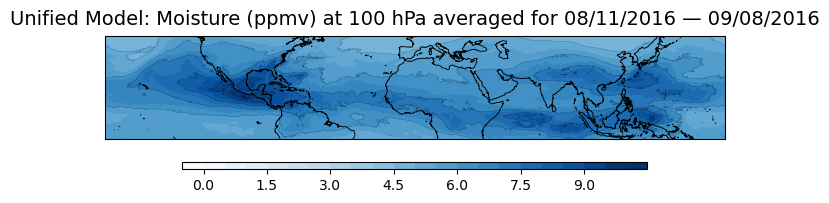

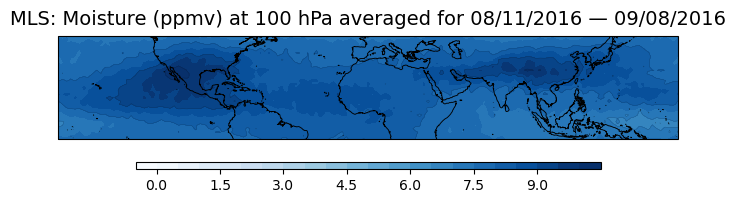

Mean value
UM: 6.381552732847082 
MLS: 6.4353013


In [47]:
# Moisture at 100 hPa (UM)
CreateMap(UM_hus100,  UM_lat,  UM_lon,  UM_name, date_range, 100)

# Moisture at 100 hPa (MLS)
CreateMap(MLS_h2o100)

# Mean moisture values
print("Mean value\nUM:", np.mean(UM_hus100),"\nMLS:", np.mean(MLS_h2o100))